In [1]:
import os
import random

from einops import rearrange
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from skimage.feature import hog
from tqdm import tqdm

import nn
import nn.layers
import nn.activations
import nn.losses
import nn.network
import nn.callbacks

### Presenting data

In [2]:
def read_images(path, size=64):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    images, _ = zip(*ds)
    images = np.concatenate(images)
    return images

In [3]:
train_images = read_images('data/train/')
test_images = read_images('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [4]:
print(labels)

['fish', 'five', 'four', 'mega', 'mirror', 'pyra', 'square', 'squeb', 'three', 'two']


In [5]:
def show_random_images(images, cmap=None):
    choosen = random.choices(images, k=25)
    choosen = rearrange(choosen, '(nh nw) h w c -> (nh h) (nw w) c', nw=5).astype(int)
    plt.imshow(choosen, cmap)

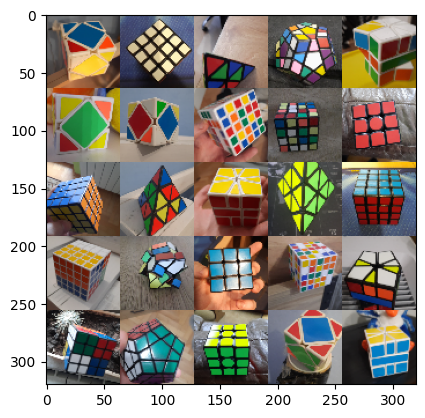

In [6]:
show_random_images(train_images)

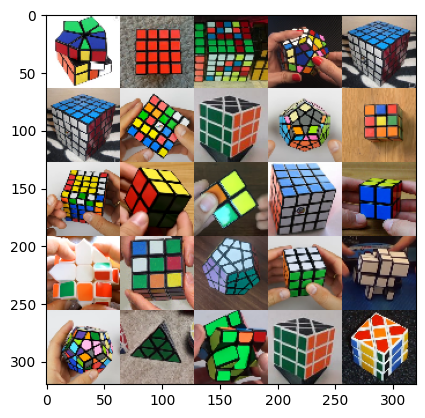

In [7]:
show_random_images(test_images)

# HOG

In [8]:
def apply_hog(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    result = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None, feature_vector=False)
    return np.squeeze(result)

In [9]:
def read_hog_images(path, size):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
        batch_size=1
    )
    
    X = []
    y = []
    
    for rgb_image, label in tqdm(ds, total=len(ds)):
        hog_image = apply_hog(rgb_image[0].numpy())
        X.append(hog_image)
        y.append(label[0].numpy())
        
    X = np.array(X)
    y = np.array(y)
    return X.astype(np.float64), y.astype(np.float64)

In [10]:
train_X, train_y = read_hog_images('data/train/', size=512)
test_X, test_y = read_hog_images('data/test/', size=512)

Found 10019 files belonging to 10 classes.


100%|██████████| 10019/10019 [07:37<00:00, 21.91it/s]


Found 500 files belonging to 10 classes.


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


### Creating CNN

In [11]:
layers = [
    nn.layers.InputLayer((32, 32, 9)),
    
    nn.layers.Conv2DLayer(32, kernel_size=3),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.Conv2DLayer(64, kernel_size=3),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.Pool2DLayer(2, 'max'),
    nn.layers.Conv2DLayer(128, kernel_size=3),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.Pool2DLayer(2, 'max'),
    nn.layers.Conv2DLayer(256, kernel_size=3),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.FlattenLayer(),
    
    nn.layers.DenseLayer(256),
    nn.layers.BiasLayer(),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.DropoutLayer(0.5),
    nn.layers.DenseLayer(128),
    nn.layers.BiasLayer(),
    nn.layers.ActivationLayer('relu'),
    
    nn.layers.DropoutLayer(0.5),
    nn.layers.DenseLayer(10),
    nn.layers.BiasLayer(),
]

model = nn.network.Sequential(layers)

In [12]:
model.compile(
    loss='softmax_cce',
    metrics=['categorical_accuracy']
)

In [13]:
model.summary()

NO   | NAME                 | PARAMS     | INPUT           | OUTPUT         
0    | InputLayer           | 0          | (32, 32, 9)     | (32, 32, 9)    
1    | Conv2DLayer          | 2624       | (32, 32, 9)     | (30, 30, 32)   
2    | ActivationLayer      | 0          | (30, 30, 32)    | (30, 30, 32)   
3    | Conv2DLayer          | 18496      | (30, 30, 32)    | (28, 28, 64)   
4    | ActivationLayer      | 0          | (28, 28, 64)    | (28, 28, 64)   
5    | Pool2DLayer          | 0          | (28, 28, 64)    | (14, 14, 64)   
6    | Conv2DLayer          | 73856      | (14, 14, 64)    | (12, 12, 128)  
7    | ActivationLayer      | 0          | (12, 12, 128)   | (12, 12, 128)  
8    | Pool2DLayer          | 0          | (12, 12, 128)   | (6, 6, 128)    
9    | Conv2DLayer          | 295168     | (6, 6, 128)     | (4, 4, 256)    
10   | ActivationLayer      | 0          | (4, 4, 256)     | (4, 4, 256)    
11   | FlattenLayer         | 0          | (4, 4, 256)     | (4096,)        

In [14]:
last_checkpoint_callback = nn.callbacks.ModelCheckpoint('saved_models/own_last.dat', verbose=True)
best_checkpoint_callback = nn.callbacks.ModelCheckpoint('saved_models/own_best.dat', save_best_only=True, monitor='val_loss', mode='min', verbose=True)
stopping_callback = nn.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    learning_rate=0.001,
    epochs=10,
    callbacks=[last_checkpoint_callback, best_checkpoint_callback, stopping_callback],
)

Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 121.55it/s, val_loss=2.3006, val_categorical_accuracy=0.1220]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 115.69it/s, val_loss=2.1027, val_categorical_accuracy=0.2180]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 115.92it/s, val_loss=1.5975, val_categorical_accuracy=0.4140]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 111.04it/s, val_loss=1.4734, val_categorical_accuracy=0.4780]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 124.62it/s, val_loss=1.4533, val_categorical_accuracy=0.5240]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 128.30it/s, val_loss=1.2574, val_categorical_accuracy=0.5820]


Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 126.13it/s, val_loss=1.5181, val_categorical_accuracy=0.5760]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 124.61it/s, val_loss=1.5294, val_categorical_accuracy=0.5980]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 127.11it/s, val_loss=1.6761, val_categorical_accuracy=0.5560]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:04<00:00, 122.27it/s, val_loss=1.0770, val_categorical_accuracy=0.6900]

Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


In [26]:
history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    learning_rate=0.001,
    epochs=5,
    callbacks=[last_checkpoint_callback, best_checkpoint_callback, stopping_callback],
)

Saving model to saved_models/own_last.dat
Saving model to saved_models/own_best.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 127.69it/s, val_loss=1.7022, val_categorical_accuracy=0.6120]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 126.83it/s, val_loss=1.6267, val_categorical_accuracy=0.6340]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 125.36it/s, val_loss=1.9456, val_categorical_accuracy=0.6180]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 125.55it/s, val_loss=1.5104, val_categorical_accuracy=0.6560]


Saving model to saved_models/own_last.dat


Validate: 100%|██████████| 500/500 [00:03<00:00, 126.98it/s, val_loss=1.9405, val_categorical_accuracy=0.6520]

Saving model to saved_models/own_last.dat


### Results

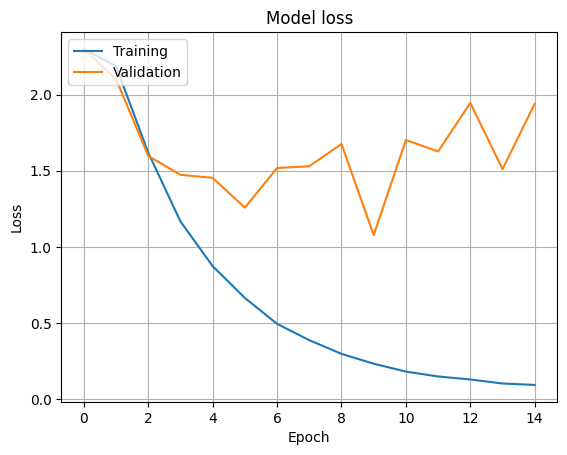

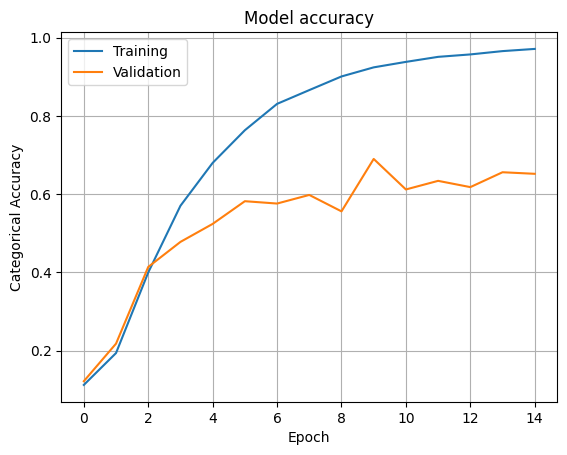

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.show()

Predict: 100%|██████████| 500/500 [00:03<00:00, 151.41it/s]


              precision    recall  f1-score   support

           0       0.58      0.50      0.54        50
           1       0.62      0.94      0.75        50
           2       0.83      0.38      0.52        50
           3       0.96      0.86      0.91        50
           4       0.66      0.46      0.54        50
           5       0.79      0.96      0.86        50
           6       0.37      0.92      0.53        50
           7       0.97      0.72      0.83        50
           8       0.65      0.66      0.65        50
           9       1.00      0.12      0.21        50

    accuracy                           0.65       500
   macro avg       0.74      0.65      0.63       500
weighted avg       0.74      0.65      0.63       500



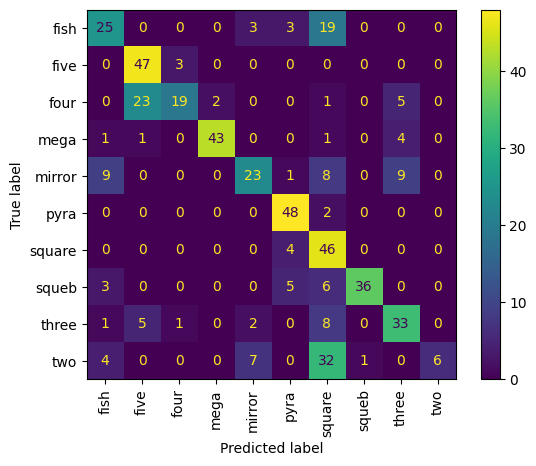

In [28]:
predictions = model.predict(test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);